In [73]:
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sparcscore.pipeline.classification import CellFeaturizer
from sparcscore.pipeline.extraction import HDF5CellExtraction
from sparcscore.pipeline.project import Project
from sparcscore.pipeline.selection import LMDSelection
from sparcscore.pipeline.workflows import CytosolSegmentationCellpose

In [74]:
project_location = "project"

project = Project(
    os.path.abspath(project_location),
    config_path="config_example2.yml",
    overwrite=False,
    debug=True,
    segmentation_f=CytosolSegmentationCellpose,
    extraction_f=HDF5CellExtraction,
    classification_f=CellFeaturizer,
    selection_f=LMDSelection,
)

modifying config
[09/01/2024 15:07:40] Loading config from /Users/sophia/Documents/GitHub/SPARCSpy/example_data/example_2/project/config.yml
[09/01/2024 15:07:40] current run: 0


/Users/sophia/Documents/GitHub/SPARCSpy/src/sparcscore/pipeline/project.py:108: UserWarning: Theres already a directory in the location path
  warnings.warn("Theres already a directory in the location path")


In [75]:
# these example images are downloaded from the human protein atlas (www.proteinatlas.org)
images = ["./input_images/ch1.tif", "./input_images/ch2.tif", "./input_images/ch3.tif"]

project.load_input_from_file(images)

(3, 290, 299)


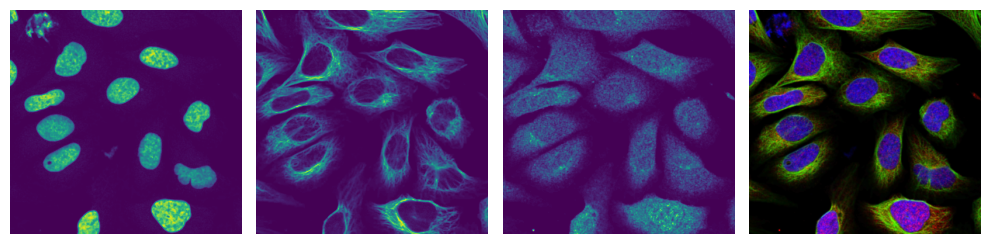

In [76]:
# visualize input images as example
# it is not recommended to execute this block with large input images as it will compute for some time


def colorize(im, color, clip_percentile=0.0):
    """
    Helper function to create an RGB image from a single-channel image using a
    specific color.
    """
    # Check that we do just have a 2D image
    if im.ndim > 2 and im.shape[2] != 1:
        raise ValueError("This function expects a single-channel image!")

    # Rescale the image according to how we want to display it
    im_scaled = im.astype(np.float32) - np.percentile(im, clip_percentile)
    im_scaled = im_scaled / np.percentile(im_scaled, 100 - clip_percentile)
    im_scaled = np.clip(im_scaled, 0, 1)

    # Need to make sure we have a channels dimension for the multiplication to work
    im_scaled = np.atleast_3d(im_scaled)

    # Reshape the color (here, we assume channels last)
    color = np.asarray(color).reshape((1, 1, -1))
    return im_scaled * color


def generate_composite(images, colors=None, plot=False):
    if colors is None:
        colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0), (1, 0, 1)]
    colorized = []
    for image, color in zip(images, colors, strict=False):
        image = colorize(image, color, 0.0)
        colorized.append(image)

    if plot:
        for i in colorized:
            plt.figure()
            plt.imshow(i)

    image = colorized[0]
    for i in range(len(colorized) - 1):
        image += colorized[i + 1]

    return np.clip(image, 0, 1)


fig, axs = plt.subplots(1, 4, figsize=(10, 4))
axs[0].imshow(project.input_image[0])
axs[0].axis("off")

axs[1].imshow(project.input_image[1])
axs[1].axis("off")

axs[2].imshow(project.input_image[2])
axs[2].axis("off")

img = generate_composite(project.input_image)

axs[3].imshow(img)
axs[3].axis("off")

fig.tight_layout()

[09/01/2024 15:07:41] current process: <_MainProcess name='MainProcess' parent=None started>
[09/01/2024 15:07:41] cpu name: MainProcess
[09/01/2024 15:07:41] running on default GPU.
[09/01/2024 15:07:41] Using MPS backend for segmentation.
[09/01/2024 15:07:41] GPU Status for segmentation: True
[09/01/2024 15:07:41] Segmenting nuclei using the following model: nuclei
[09/01/2024 15:07:42] Segmenting cytosol using the following model: cyto2
[09/01/2024 15:07:43] Number of nuclei to filter: 15
[09/01/2024 15:07:43] saving segmentation
[09/01/2024 15:07:43] === finished segmentation ===


/Users/sophia/Documents/GitHub/SPARCSpy/src/sparcscore/pipeline/workflows.py:821: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


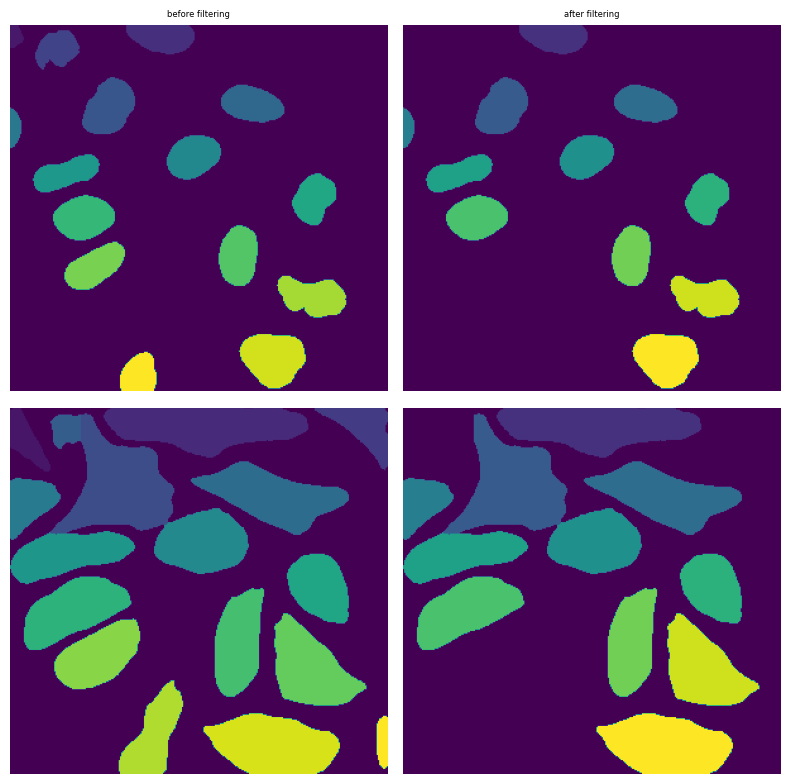

In [77]:
project.segment()

<HDF5 dataset "labels": shape (2, 290, 299), type "<u4">


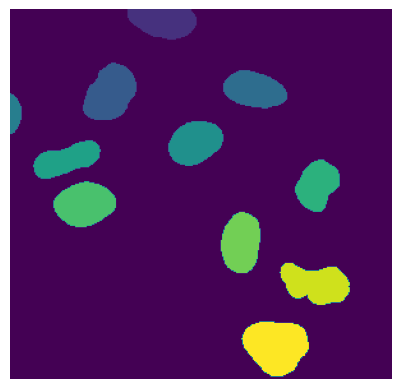

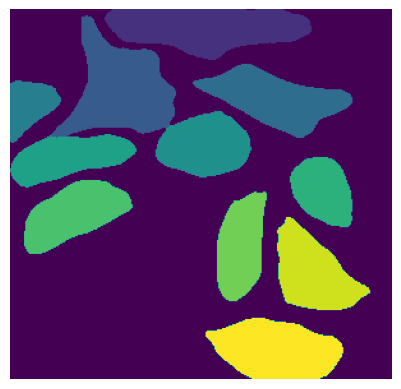

In [78]:
with h5py.File(f"{project_location}/segmentation/segmentation.h5") as hf:
    segmentation = hf.get("labels")
    print(segmentation)

    plt.figure()
    plt.imshow(segmentation[0])
    plt.axis("off")

    plt.figure()
    plt.imshow(segmentation[1])
    plt.axis("off")

In [79]:
project.extract()

[09/01/2024 15:07:44] Using channel label <HDF5 dataset "channels": shape (3, 290, 299), type "<u2">
[09/01/2024 15:07:44] Using segmentation label <HDF5 dataset "labels": shape (2, 290, 299), type "<u4">
[09/01/2024 15:07:44] Created new extraction cache ./3f0cc6d7-3667-4754-93d7-209d99bdb151
[09/01/2024 15:07:44] Started extraction
[09/01/2024 15:07:44] Loading segmentation data from {input_segmentation_path}
[09/01/2024 15:07:44] Using channel label <HDF5 dataset "channels": shape (3, 290, 299), type "<u2">
[09/01/2024 15:07:44] Using segmentation label <HDF5 dataset "labels": shape (2, 290, 299), type "<u4">
[09/01/2024 15:07:44] Finished loading channel data (3, 290, 299)
[09/01/2024 15:07:44] Finished loading label data (2, 290, 299)
[09/01/2024 15:07:44] Checked class coordinates
[09/01/2024 15:07:44] Cached version found, loading
[09/01/2024 15:07:44] Loading filtered classes from /Users/sophia/Documents/GitHub/SPARCSpy/example_data/example_2/project/segmentation/classes.csv
[0

extracting classes: 11it [00:00, 260.64it/s]

[09/01/2024 15:07:44] Extracting dataset 0
[09/01/2024 15:07:44] Finished extraction in 0.04 seconds (253.01 cells / second)
[09/01/2024 15:07:44] Collect cells
[09/01/2024 15:07:44] number of cells too close to image edges to extract: 4
[09/01/2024 15:07:44] Transferring extracted single cells to .hdf5
[09/01/2024 15:07:44] index created.
[09/01/2024 15:07:44] Tempmmap Folder location /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./temp_mmapgjvga3gr will now be removed.
[09/01/2024 15:07:44] Finished cleaning up cache


(7, 5, 110, 110)


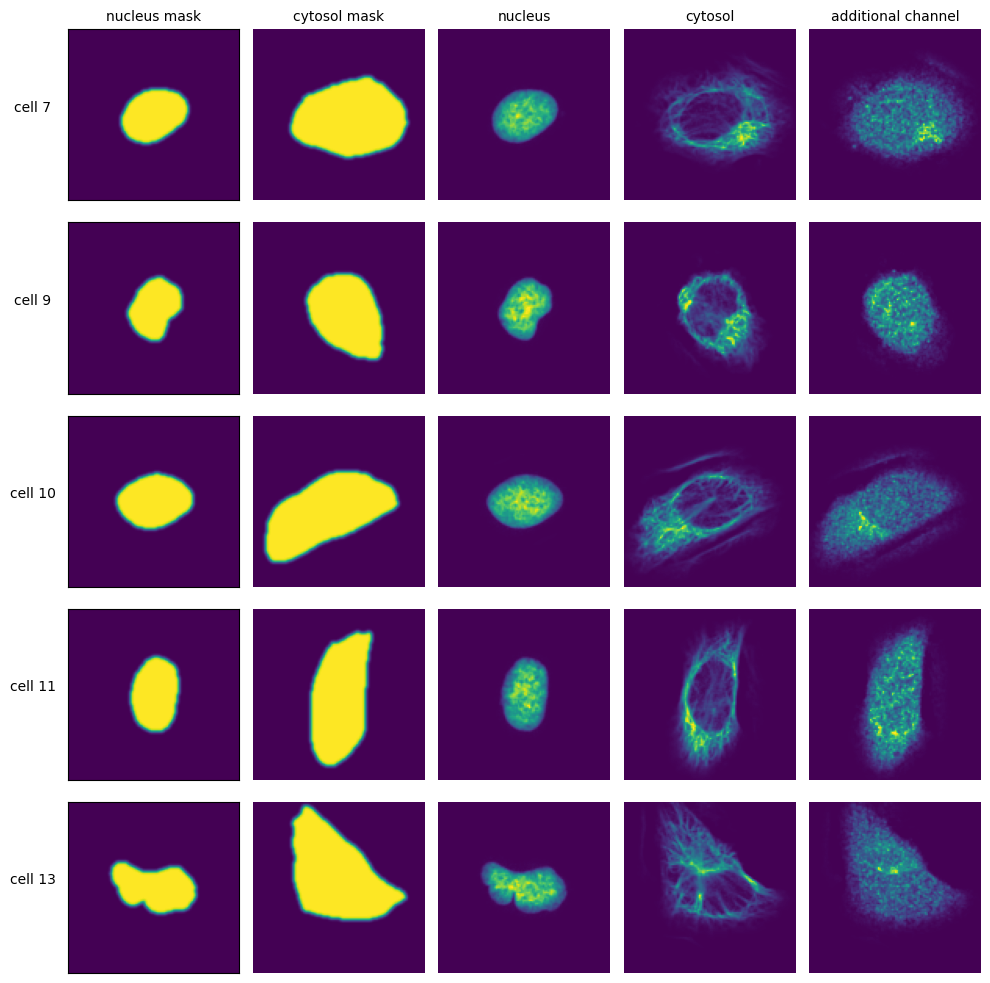

In [85]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    images = hf.get("single_cell_data")

    print(images.shape)

    n_cells = [2, 3, 4, 5, 6]
    fig, axs = plt.subplots(len(n_cells), 5, figsize=(5 * 2, len(n_cells) * 2))
    labels = ["nucleus mask", "cytosol mask", "nucleus", "cytosol", "additional channel"]

    for i, id in enumerate(n_cells):
        cell_id = index[id][1]
        image = images[id]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize=10, rotation=0, labelpad=25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")

            if i == 0:
                axs[i, n].set_title(labels[n], fontsize=10)

    fig.tight_layout()

In [82]:
project.classify(accessory=[(), (), ()])

[09/01/2024 15:07:44] Started classification
[09/01/2024 15:07:44] starting with run 0
[09/01/2024 15:07:44] channel_classification: 4
[09/01/2024 15:07:44] batch_size: 900
[09/01/2024 15:07:44] dataloader_worker: 0
[09/01/2024 15:07:44] inference_device: cpu
[09/01/2024 15:07:44] screen_label: Ch3_Featurization
[09/01/2024 15:07:44] 0 different accessory datasets specified
[09/01/2024 15:07:44] loading /Users/sophia/Documents/GitHub/SPARCSpy/example_data/example_2/project/extraction/data
[09/01/2024 15:07:44] Total: 7
[09/01/2024 15:07:44] 0: 7
[09/01/2024 15:07:44] 
[09/01/2024 15:07:44] start processing 1 batches
[09/01/2024 15:07:44] finished processing


/Users/sophia/mambaforge/envs/SPARCS-dev/lib/python3.10/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


In [89]:
# load classification results
results = pd.read_csv(f"{project_location}/classification/0_Ch3_Featurization/calculated_features.tsv", index_col=0)
results

,nucleus_area,cytosol_area,mean,median,quant75,quant25,summed_intensity_nucleus_area,summed_intensity_cytosol_area,summed_intensity_nucleus_area_normalized,summed_intensity_cytosol_area_normalized,label,cell_id
0,2046.0,6251.0,0.129013,0.048767,0.220825,0.000989,776.21967,1561.0576,0.379384,0.249729,0,4
1,1832.0,3528.0,0.092247,0.000019,0.050392,0.000000,772.75350,1116.1913,0.421809,0.316381,0,11
2,1600.0,2841.0,0.065608,0.000000,0.008703,0.000000,635.60034,793.8561,0.397250,0.279428,0,9
3,1756.0,4319.0,0.108168,0.000188,0.113968,0.000000,766.66050,1308.8384,0.436595,0.303042,0,5
4,2021.0,4259.0,0.074713,0.001058,0.100952,0.000000,544.54150,904.0216,0.269442,0.212261,0,13
5,1981.0,4059.0,0.080214,0.003530,0.090057,0.000000,561.52045,970.5878,0.283453,0.239120,0,10
6,1768.0,3841.0,0.086871,0.001493,0.098114,0.000000,635.65830,1051.1416,0.359535,0.273664,0,7
